In [30]:
import pandas as pd
import glob
import os
import janitor
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

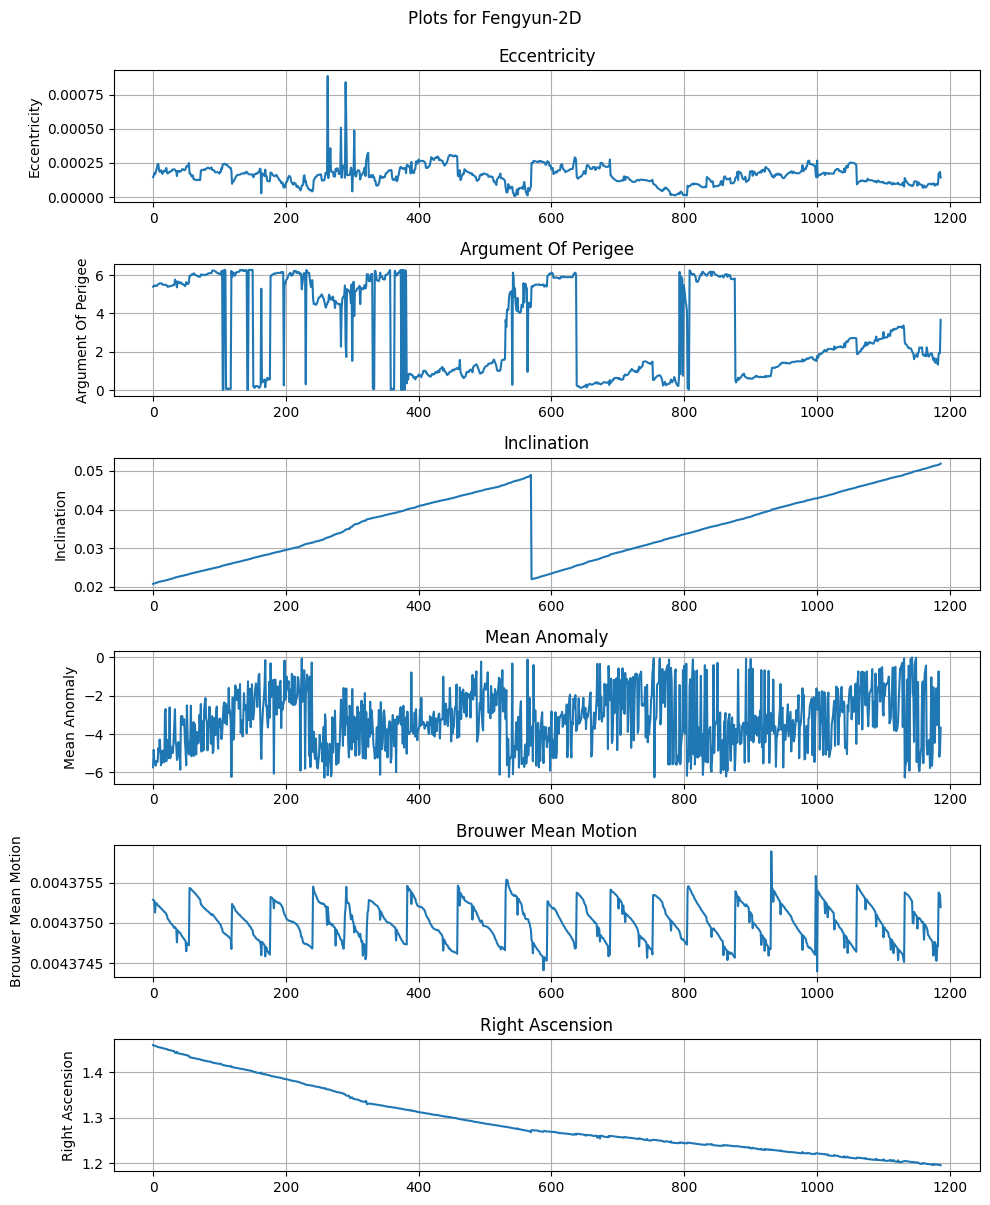

In [31]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_Fengyun-2D.csv"

# Function to remove outliers using IQR method
def remove_outliers_iqr(df):
    numeric_df = df.select_dtypes(include = ['float64','int64'])
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = numeric_df[~((numeric_df < lower_bound) | (numeric_df > upper_bound)).any(axis = 1)]
    return filtered_df

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path)

# Converting the column names into snake case for clarity
df = df.clean_names()

# Converting column name unnamed_0 to date_time
df.rename(columns={'unnamed_0':'date_time'}, inplace=True)

# Converting date_time into dattime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Removing outliers from the numeric data
filtered_numeric_df = remove_outliers_iqr(df)

# Recombining the non-numeric data with the filtered numeric data
non_numeric_df = df.select_dtypes(exclude = ['float64','int64'])
filtered_df = pd.concat([filtered_numeric_df, non_numeric_df], axis = 1)

# Setting date_time column as index
filtered_df.set_index('date_time',inplace = True)

columns_to_plot = filtered_df.columns
num_columns = len(columns_to_plot)

# Creating a figure with subplots for each column of data
fig, axes = plt.subplots(nrows = num_columns, ncols = 1, figsize = (10,2*num_columns), sharex = False)

# Plotting each column in its own subplot
for x, column in enumerate(columns_to_plot):
    ax = axes[x]
    df[column].plot(ax = ax, title = column.replace('_',' ').title())
    ax.set_ylabel(column.replace('_',' ').title())
    ax.grid(True)

plt.suptitle("Plots for Fengyun-2D", y = 1)
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

In [32]:
# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/manFY2D.txt.fy'

data = []

# Reading the file data into the list
with open(maneuver_file_path, 'r') as file:
    for line in file:
        # Splitting the line by space
        parts = line.strip().split('"')
        #maneuver_type, satellite_id = parts[0].strip().split()[:2]
        start_date = parts[1]
        #end_time = parts[3]
        data.append(start_date)

# Defining the column names
column_names = ['Start_Date']

# Creating a dataframe with the text file data
df = pd.DataFrame(data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'] = pd.to_datetime(df['Start_Date'])

# Checking the dataframe
print(df.head())

           Start_Date
0 2015-04-10 15:30:00
1 2015-01-27 14:30:00
2 2014-10-24 15:30:00
3 2014-08-04 15:30:00
4 2014-05-09 15:30:00


/var/folders/5m/f9w6_kb12kn6r38z9rjzgfk00000gn/T/ipykernel_4591/2644158969.py:23: FutureWarning: Parsed string "2015-04-10T15:30:00 CST" included an un-recognized timezone "CST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Start_Date'] = pd.to_datetime(df['Start_Date'])


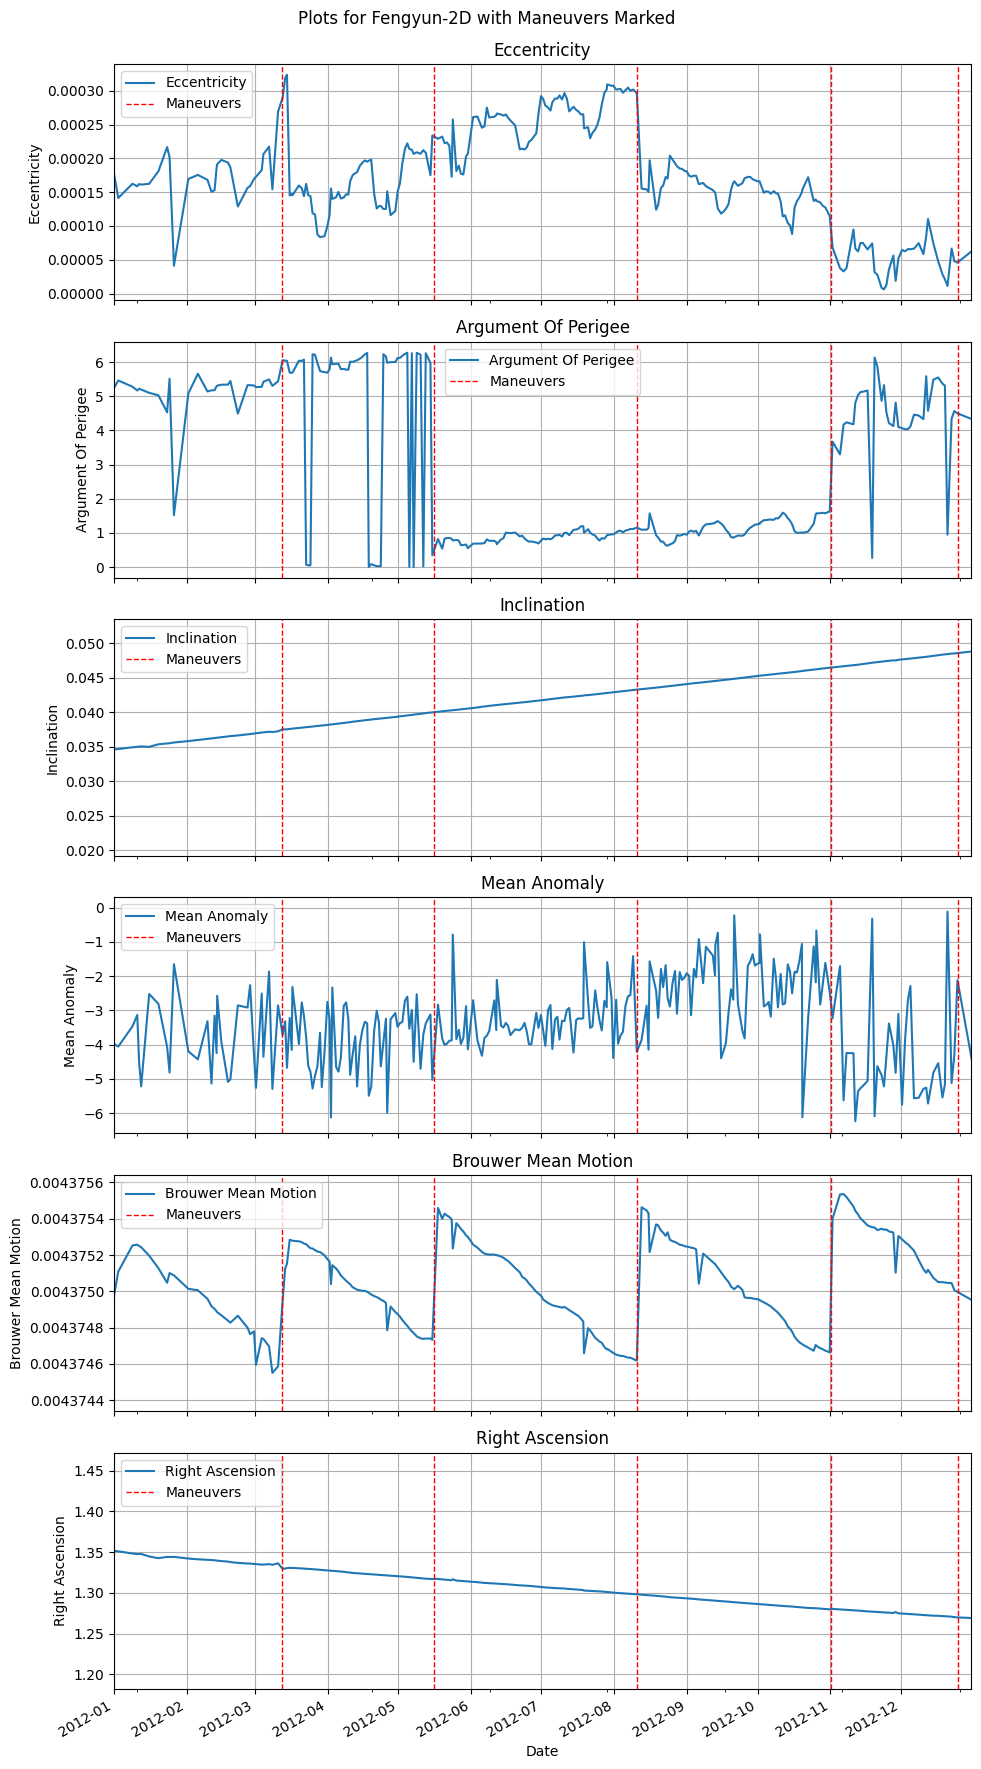

In [33]:
# Function to mark maneuvers on plots
def mark_maneuver_start_on_plot(ax,df):
    for _, row in df.iterrows():
        if pd.notna(row['Start_Date']):
            ax.axvline(x = row['Start_Date'], color = 'red', linestyle = '--', linewidth = 1, label = 'Maneuvers')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels,handles))
    ax.legend(by_label.values(),by_label.keys())

# Defining the date ranges for the plots
start_date = pd.to_datetime('2012-01-01')
end_date = pd.to_datetime('2012-12-31')

columns_to_plot = filtered_df.columns
num_columns = len(columns_to_plot)

# Creating a figure with subplots for each column of data
fig, axes = plt.subplots(nrows = num_columns, ncols = 1, figsize = (10,3*num_columns), sharex = True)

# Plotting each column in its own subplot
for x, column in enumerate(columns_to_plot):
    ax = axes[x]
    filtered_df[column].plot(ax = ax, title = column.replace('_',' ').title(), label = column.replace('_',' ').title())

    # Marking maneuvers
    mark_maneuver_start_on_plot(ax,df)

    # Setting x axis limits
    ax.set_xlim(start_date,end_date)
    ax.set_xlabel("Date")

    ax.set_ylabel(column.replace('_',' ').title())
    ax.grid(True)

plt.suptitle("Plots for Fengyun-2D with Maneuvers Marked")
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

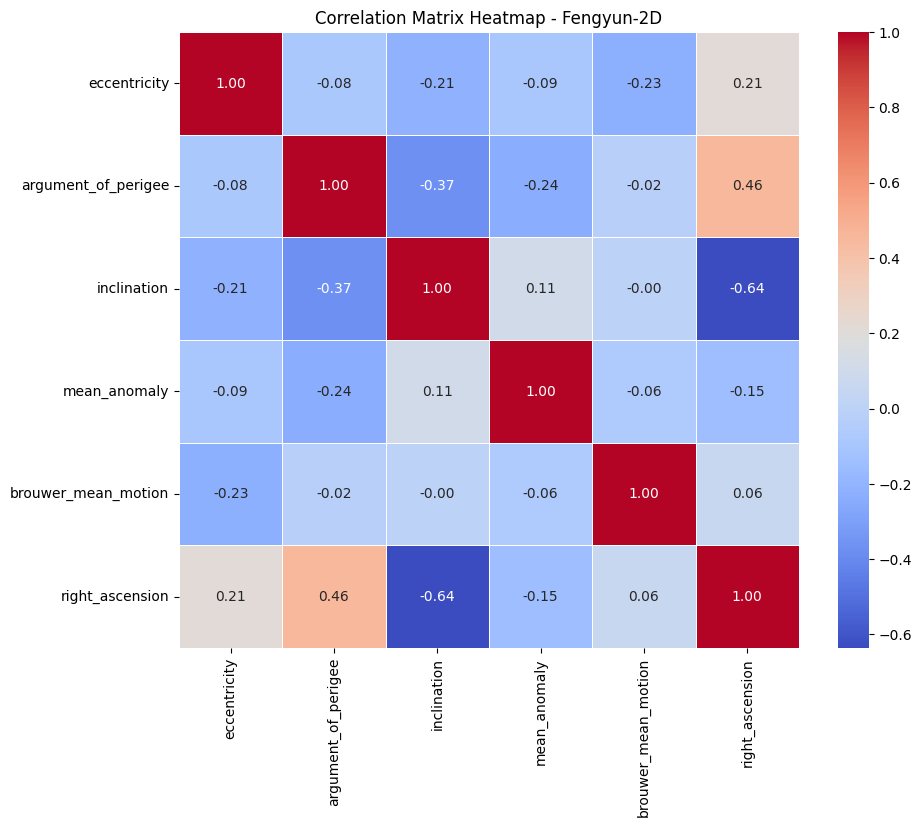

In [34]:
# Calculating the correlation matrix
correlation_matrix = filtered_df.corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.5)
plt.title("Correlation Matrix Heatmap - Fengyun-2D")
plt.show()